### Goal: Train a model to segment nucleii from C. elegans Fluorescence Microscopy data

In [ ]:
!pip install albumentations  
!pip install segmentation-models-pytorch
!pip install optuna

In [ ]:
import os, sys
import numpy as np
import cv2
from PIL import Image
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

import segmentation_models_pytorch as smp
from albumentations import *
import time
import optuna

from os import listdir
from os.path import isfile, join
import csv
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Copy Preprocessed data from GDrive:

In [ ]:
!cp /content/drive/MyDrive/mydata/celltrackingchallenge/nucleus_seg_data.zip /content/
!unzip /content/nucleus_seg_data.zip

### Resize Images to 256x256

In [ ]:
def resize(path):
  dirs = os.listdir( path )
  for item in tqdm(dirs):
    if os.path.isfile(path+item):
      im = Image.open(path+item)
      f, e = os.path.splitext(path+item)
      imResize = im.resize((256,256), Image.NEAREST)
      imResize.save(f+e, 'PNG', quality=100)
      
features_path, label_path = "/content/features/", "/content/segmentation_maps/"
resize(label_path)
resize(features_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Create a csv containing image id's

In [ ]:
ids=[]
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
  ids.append(label_filenames[i][1:])
print(len(ids))

df = pd.DataFrame(ids ,columns=["file_ids"])
df.to_csv('file_ids.csv', index=False)

#sanity check
df = pd.read_csv('file_ids.csv')
df.head()

6790


,file_ids
0,59_12.png
1,37_34.png
2,13_8.png
3,33_21.png
4,169_29.png


### Define Custom Dataset Class

In [ ]:
class SegmentationDataset(Dataset):   
    def __init__(self, csv, augmentation =None, transform_image = None, transform_label = None):

        self.df = pd.read_csv(csv)
        self.ids  = self.df["file_ids"]
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augmentation = augmentation

    def __getitem__(self, idx):
        image= np.array(Image.open("/content/features/F"+self.ids[idx]))
        mask=np.array(Image.open("/content/segmentation_maps/L"+self.ids[idx]))
        if self.augmentation is not None:
                
            augmented  = self.augmentation(image = image, mask = mask)
            image = augmented["image"]
            mask = augmented["mask"]
       
        mask[mask != 0] = 1
        mask = self.transform_label(mask)
        mask = mask.float()
        return self.transform_image(image), mask
    
    def __len__(self):
        return len(self.ids)

### Define a class to add gaussian noise in images

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
full_dataset = SegmentationDataset(csv = "file_ids.csv",
                                    augmentation =  Compose([
                                                            GridDistortion(p=0.5),
                                                            Transpose(p=0.5),
                                                            VerticalFlip(p=0.5),
                                                            HorizontalFlip(p=0.5),
                                                            RandomRotate90(p=0.5),
                                                            ShiftScaleRotate(p=0.1),
                                                            OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=1),
                                                            ]),

                                    transform_image = transforms.Compose([ 
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),
                                                                    transforms.RandomApply([AddGaussianNoise( mean = 0.5,std= 0.05)], p=0.5)
                                                                ]),                                  
                                    transform_label = transforms.Compose([ 
                                                                                                        
                                                                    transforms.ToPILImage(),
                                                                    ToTensor(),

                                                                ]))

In [ ]:
train_batch_size = 32
train_size = int(0.8* len(full_dataset))  ## 80/20 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=test_dataset, batch_size= 4, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")
sample = next(iter(train_loader))

340 batches 
340  batches 


Test Dataloader

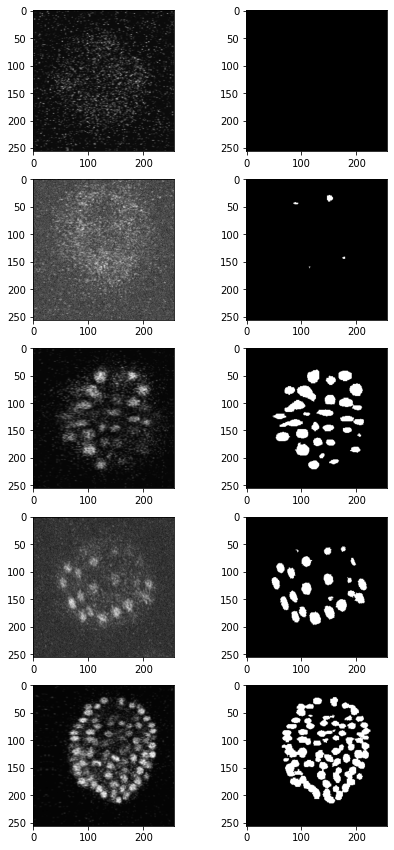

In [ ]:
batch  = next(iter(train_loader))
images, masks = batch
fig, ax = plt.subplots(5, 2, figsize = (7,15))
for i in range(5):
    ax[i][0].imshow(images[i][0], cmap='gray')
    ax[i][1].imshow(masks[i][0], cmap='gray')

In [ ]:
def plot_metrics(train_iou_scores, valid_iou_scores, val_dice_losses, lrs):

    plt.rcParams['figure.figsize'] = 15, 4
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    clear_output(wait = True)
    ax1.plot(train_iou_scores, color='blue', label='train')
    ax1.plot(valid_iou_scores, color='green', label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_title('iou scores')
    ax2.plot(val_dice_losses, color = "green")
    ax2.grid()
    ax2.set_title('val dice loss')
    ax3.plot(lrs, color = "red")
    ax3.grid()
    ax3.set_title('learning rates')
    plt.show()


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [ ]:
def run_training(epochs=2, lr=0.00015, batch_size=32, loss=loss, show_metrics=True, device='cuda', optuna=False):
    '''
    epochs: number of training epochs
    lr: learning rate
    batch_size: training batch size
    show metrics: to enable/disable plots
    device: choose b/w CPU and GPU based training
    optuna: Setting True will lead to loading only 10% of available data, for faster trials
    '''
    model = smp.FPN(
    encoder_name='resnet18', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
    in_channels = 1
    )

    optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=lr), 
    ])

    trainer = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=device,
        verbose=show_metrics,
        )

    validator = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=device,
        verbose=False,
    )
   
    scheduler = ReduceLROnPlateau(optimizer, 
                                    mode='min', 
                                    factor=0.7, 
                                    patience=7, 
                                    verbose=False, 
                                    threshold=0.0001, 
                                    threshold_mode='rel', 
                                    cooldown=0, 
                                    min_lr=0, 
                                    eps=1e-08)
    
    max_score = 0
    val_dice_losses, train_iou_scores, val_iou_scores, lrs = [],[],[],[]
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle = True, num_workers=2)

    if optuna:
      optuna_logs = trainer.run(val_loader)
      return(optuna_logs["iou_score"])

    for i in range(0, epochs):

        print('\nEpoch: {}'.format(i))

        train_logs = trainer.run(train_loader)
        valid_logs = validator.run(val_loader)
        val_dice_losses.append(valid_logs["dice_loss"]) 
        train_iou_scores.append(train_logs["iou_score"])
        val_iou_scores.append(valid_logs["iou_score"])
        scheduler.step(1.)
        lrs.append(get_lr(optimizer))

        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')

        if show_metrics:
            plot_metrics(train_iou_scores, val_iou_scores, val_dice_losses, lrs)

    return(max_score)

### Automated Hyperparameter Optimization (Optuna):
n_trials is the number of optuna trials, feel free to use any higher number.



In [ ]:
def objective(trial):
    params = {
        "lr": trial.suggest_uniform("lr", 0.5e-3 , 20e-3 ),
        "batch_size" : trial.suggest_int("batch_size", 8 , 64, )}
        
    score  = run_training(epochs = 3,
                          lr =  params["lr"],
                          batch_size = params["batch_size"],
                          loss=loss, 
                          device=device,
                          optuna=True)

    return(score)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

### View Hyperparameters for Best Optuna Trial¶


In [ ]:
study.best_trial

FrozenTrial(number=153, values=[0.4952311981469392], datetime_start=datetime.datetime(2021, 7, 7, 14, 3, 35, 65636), datetime_complete=datetime.datetime(2021, 7, 7, 14, 3, 56, 331428), params={'lr': 0.00292656544517321, 'batch_size': 32}, distributions={'lr': UniformDistribution(high=0.02, low=0.0005), 'batch_size': IntUniformDistribution(high=64, low=8, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=153, state=TrialState.COMPLETE, value=None)

### Train model:
Args for run_training:
* epochs- number of training epochs
* lr- learning rate
* batch_size - training batch size
* show metrics- to enable/disable plots
* device- choose b/w CPU and GPU based training
* optuna- Setting True will lead to loading only 10% of available data, for faster trials

run_training automatically saves the best model as best_model.pth

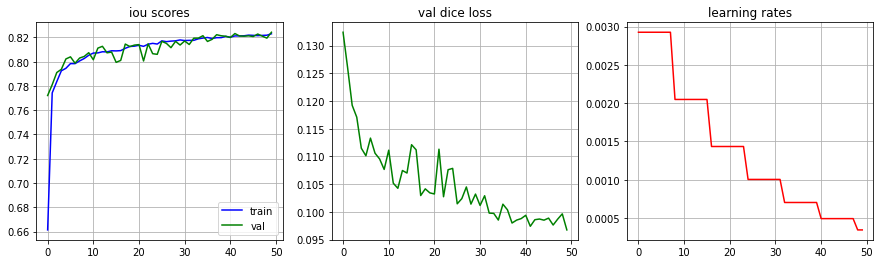

In [ ]:
best_score = run_training(epochs=50, 
                          lr=0.00292656544517321, 
                          batch_size=32,  
                          loss=loss, 
                          show_metrics=True,
                          device=device, 
                          optuna=False)

### Compare original segmentation masks with model outputs

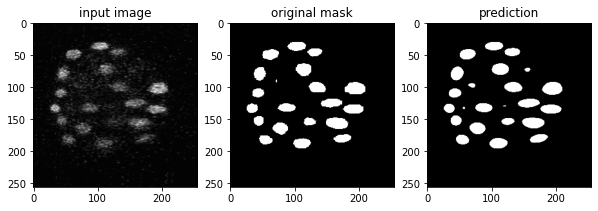

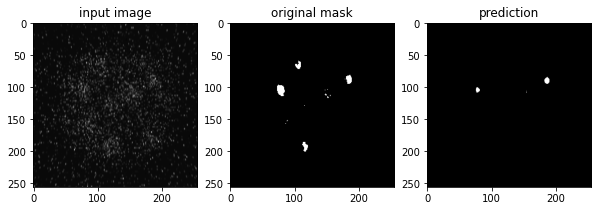

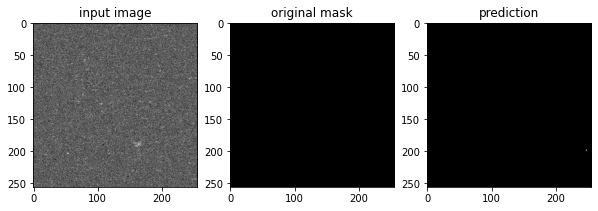

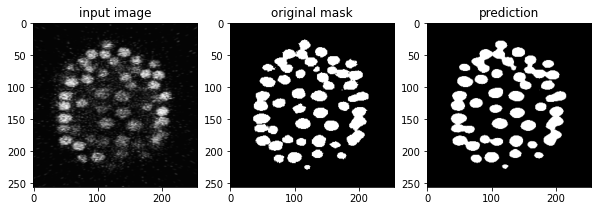

In [ ]:
image, masks = next(iter(val_loader))
model = torch.load('best_model.pth')
model.eval()
for i in range(len(image)):
    inp = image[i].cuda().unsqueeze(0)
    pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    show_img = inp.cpu()[0][0]
    show_pred = model(inp).squeeze(0).squeeze(0).detach().cpu()
    # show_pred[show_pred > 0.1] = 1
    show_mask = masks[i][0].cpu()
    fig, ax = plt.subplots(1,3, figsize = (10,120))
 
    ax.flat[0].imshow(show_img, cmap='gray')
    ax.flat[0].title.set_text('input image')
    
    ax.flat[1].imshow(show_mask, cmap='gray')
    ax.flat[1].title.set_text('original mask')
 
    ax.flat[2].imshow(show_pred, cmap='gray')
    ax.flat[2].title.set_text('prediction')

### Copy model to drive

In [ ]:
!cp -r /content/best_model.pth /content/drive/MyDrive/mydata/celltrackingchallenge/

### Generate frames for gif
After running the following cells, you'll find a folder named `animation` containing images that showcase input images and predicted segmentation maps side by side.

In [ ]:
time_ids=[]
time = '100'
label_filenames = [f for f in listdir(label_path) if isfile(join(label_path, f))]
feature_filenames = [f for f in listdir(features_path) if isfile(join(features_path, f))]
for i in range(len(label_filenames)):
    if label_filenames[i][1:4] == time:
        time_ids.append(label_filenames[i][1:])
print(time_ids)

['100_1.png', '100_29.png', '100_22.png', '100_13.png', '100_26.png', '100_31.png', '100_9.png', '100_8.png', '100_0.png', '100_25.png', '100_30.png', '100_17.png', '100_19.png', '100_3.png', '100_6.png', '100_5.png', '100_28.png', '100_23.png', '100_20.png', '100_33.png', '100_16.png', '100_11.png', '100_14.png', '100_7.png', '100_32.png', '100_21.png', '100_4.png', '100_2.png', '100_15.png', '100_18.png', '100_10.png', '100_34.png', '100_24.png', '100_27.png', '100_12.png']


In [ ]:
!mkdir animation

In [ ]:
model.eval()
root_features='/content/features/'
for path in time_ids:
    img = cv2.imread(root_features+"F"+path, 0)
    norm=(img-np.min(img))/(np.max(img)-np.min(img))
    input_tensor = torch.tensor(norm).unsqueeze(0).unsqueeze(0).float()
    #plt.imshow(img)
    # norm=(img-np.min(img))/(np.max(img)-np.min(img))
    seg = model(input_tensor.to(device))
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax.flat[0].imshow(img, cmap='gray')
    ax.flat[0].title.set_text('input')
    ax.flat[1].imshow(seg.detach().cpu()[0][0], cmap='gray')
    ax.flat[1].title.set_text('segmentation map')
    #plt.show()
    savename="/content/animation/"+path
    fig.savefig(savename)

In [ ]:
!zip -r animation.zip animation/